In [11]:
import sys
sys.path.append('../..')
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)
#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 14
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, 'Germany',
                                     date_data_begin, date_data_end)

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_median_lambda = 1,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.5,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.25,
                      pr_sigma_lambda = 1)]

model_rw = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=dict(pr_sigma_random_walk=0.1,
                                                    pr_sigma_lambda_0=1,
                                                    pr_median_lambda_0=2),
                                   with_random_walk=True)


model_not_rw = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=None,
                                   with_random_walk=False)

#trace_rw = pm.sample(model=model_rw, init='advi', draws=3000)
trace_not_rw = pm.sample(model=model_not_rw, init='advi', draws=3000)
# advi is important as initialization, other initializations methods lead
# to more divergences
path_to_save = '../../figures/'

pr_beta_I_begin was set to default value 100
pr_beta_E_begin_scale was set to default value 10
pr_median_mu was set to default value 0.3333333333333333
pr_sigma_mu was set to default value 0.3
pr_median_delay was set to default value 5
pr_sigma_delay was set to default value 0.2
scale_delay was set to default value 0.3
pr_beta_sigma_obs was set to default value 10
pr_mean_median_incubation was set to default value 5
pr_sigma_median_incubation was set to default value 1
sigma_incubation was set to default value 0.418
pr_sigma_date_begin_transient of change point 0 was set to default value 3
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_transient_len of change point 1 was set to default value 0.3
pr_sigma_transient_len of change point 2 was set to defa

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 346.48:   7%|▋         | 13687/200000 [00:47<10:51, 285.97it/s]
Convergence achieved at 13700
Interrupted at 13,699 [6%]: Average Loss = 402.87
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [median_incubation, sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, E_begin, E_begin_scale, I_begin]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [18:50<00:00, 12.38draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [12]:
print(pm.loo(trace_rw, model_rw))
print(pm.loo(trace_not_rw, model_not_rw))

Computed from 16000 by 37 log-likelihood matrix

       Estimate       SE
IC_loo   576.97    15.68
p_loo      9.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36   97.3%
 (0.5, 0.7]   (ok)          1    2.7%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Computed from 12000 by 38 log-likelihood matrix

       Estimate       SE
IC_loo   598.37    16.11
p_loo      9.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       37   97.4%
 (0.5, 0.7]   (ok)          1    2.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Plots with data from 2020-03-01 to 2020-04-08


/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:367: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


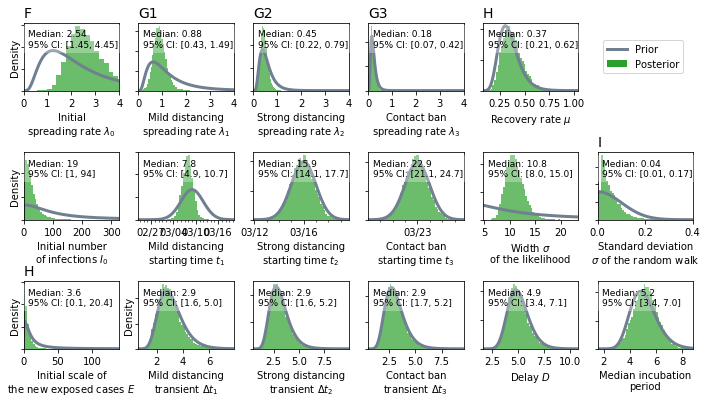

In [13]:
trace = trace_rw

def truncate_number(number, precision):
    return '{{:.{}f}}'.format(precision).format(number)  

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    return 'Median: {}\n95% CI: [{}, {}]'.format(med, perc1, perc2)
def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_begin_sim for date in arr])

print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

diff_to_0 = num_days_data + diff_data_sim 
colors = ['#708090', 'tab:green']

fig, axes = plt.subplots(3,6, figsize=(12,6))
#plt.locator_params(nbins=4)
pos_letter = (0, 1.08)
pos_median = (0.05,0.9)
size_letters=14
alpha_texbox=.3
font_text=9
horizontal_alignment_median = 'left'
horizontal_alignment_letter = 'left'
alpha_hist = 0.7
zorder_hist = -5

# LAM 0
limit_lambda = (0,4)
ax = axes[0][0]
ax.hist(trace.lambda_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=2, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial\nspreading rate $\lambda_0$')
text = print_median_CI(trace.lambda_0, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# INIT INFECTIONS
ax = axes[1][0]
ax.hist(trace.I_begin, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
ax.set_xlabel('Initial number\nof infections $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

# LAM 1
ax = axes[0][1]
ax.hist(trace.lambda_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Mild distancing\nspreading rate $\lambda_1$')
text = print_median_CI(trace.lambda_1, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

# TIME 1
ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Mild distancing\nstarting time $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=6))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

# Transient T1
ax = axes[2][1]
ax.hist(trace.transient_len_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Mild distancing\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_len_0, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)

# LAM 2
ax = axes[0][2]
ax.hist(trace.lambda_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.5, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Strong distancing\nspreading rate $\lambda_2$')
text = print_median_CI(trace.lambda_2, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G2", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 2
ax = axes[1][2]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Strong distancing\nstarting time $t_2$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))



# Transient T2
ax = axes[2][2]
ax.hist(trace.transient_len_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Strong distancing\ntransient $\Delta t_2$')
text = print_median_CI(trace.transient_len_1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# LAM 3
ax = axes[0][3]
ax.hist(trace.lambda_3, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.25, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Contact ban\nspreading rate $\lambda_3$')
text = print_median_CI(trace.lambda_3, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G3", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 3
ax = axes[1][3]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_2)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_contact_ban_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Contact ban\nstarting time $t_3$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))


# Transient T3
ax = axes[2][3]
ax.hist(trace.transient_len_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Contact ban\ntransient $\Delta t_3$')
text = print_median_CI(trace.transient_len_2, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# RECOVERY
ax = axes[0][4]
ax.hist(trace.mu, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.mu, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# WIDTH
ax = axes[1][4]
ax.hist(trace.sigma_obs, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
# ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$\nof the likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_obs, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

# DELAY
ax = axes[2][4]
ax.hist(trace.delay, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=5, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)

# E begin
ax = axes[2][0]
ax.hist(trace.E_begin_scale, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial scale of\nthe new exposed cases $E$')
text = print_median_CI(trace.E_begin_scale, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)

ax.set_xlim(0)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# sigma random walk
ax = axes[1][5]
ax.hist(trace.sigma_random_walk, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
# ax.set_ylabel('Density')
ax.set_xlabel("Standard deviation\n$\sigma$ of the random walk")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfnorm.pdf(x, scale=0.1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_random_walk, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)
ax.set_xlim(0)

# DELAY
ax = axes[2][5]
ax.hist(trace.median_incubation, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=5, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Median incubation\nperiod')
text = print_median_CI(trace.median_incubation, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)


#plt.tight_layout()

ax = axes[0][5]
ax.set_axis_off()
ax.plot([],[], color=colors[0], linewidth=3, label='Prior')
ax.hist([], color=colors[1], label='Posterior')
ax.legend(loc='center left')


for ax_row in axes:
    for idx, ax in enumerate(ax_row):
        if idx == 0:
            ax.set_ylabel('Density')
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4)
        ax.set_rasterization_zorder(-1)
        #ax.xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.2, hspace=.9)
# fig.tight_layout()
plt.savefig(path_to_save + 'SEIR_rw_distr.png',  bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig(path_to_save + 'SEIR_rw_distr.pdf',  bbox_inches = 'tight', pad_inches = 0, dpi=300)

Plots with data from 2020-03-01 to 2020-04-08


/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:341: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.DayLocator'>


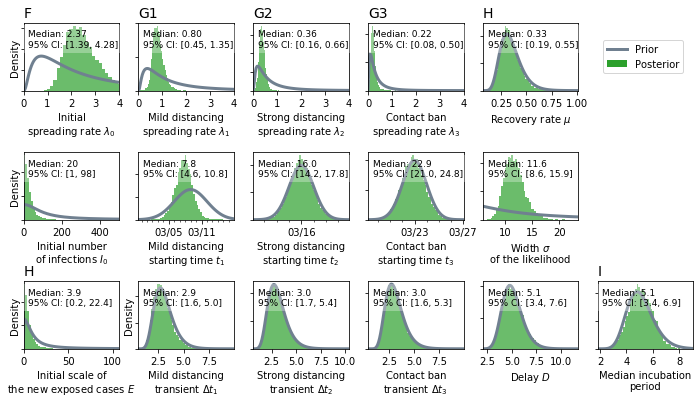

In [17]:
trace = trace_not_rw

print("Plots with data from {} to {}".format(date_data_begin.date().isoformat(), date_data_end.date().isoformat()))

diff_to_0 = num_days_data + diff_data_sim 
colors = ['#708090', 'tab:green']

fig, axes = plt.subplots(3,6, figsize=(12,6))
#plt.locator_params(nbins=4)
pos_letter = (0, 1.08)
pos_median = (0.05,0.9)
size_letters=14
alpha_texbox=.3
font_text=9
horizontal_alignment_median = 'left'
horizontal_alignment_letter = 'left'
alpha_hist = 0.7
zorder_hist = -5

# LAM 0
limit_lambda = (0,4)
ax = axes[0][0]
ax.hist(trace.lambda_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=2, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial\nspreading rate $\lambda_0$')
text = print_median_CI(trace.lambda_0, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# INIT INFECTIONS
ax = axes[1][0]
ax.hist(trace.I_begin, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
ax.set_xlabel('Initial number\nof infections $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "K", transform=ax.transAxes, size=size_letters)
plt.subplots_adjust(hspace=0.5)

# LAM 1
ax = axes[0][1]
ax.hist(trace.lambda_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Mild distancing\nspreading rate $\lambda_1$')
text = print_median_CI(trace.lambda_1, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

dates_mild = conv_time_to_mpl_dates(trace.transient_begin_0)

# TIME 1
ax = axes[1][1]
ax.hist(dates_mild, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_mild_dist_begin])[0], scale=3), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Mild distancing\nstarting time $t_1$')
text = print_median_CI(dates_mild - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=6))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

# Transient T1
ax = axes[2][1]
ax.hist(trace.transient_len_0, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Mild distancing\ntransient $\Delta t_1$')
text = print_median_CI(trace.transient_len_0, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=size_letters)

# LAM 2
ax = axes[0][2]
ax.hist(trace.lambda_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.5, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Strong distancing\nspreading rate $\lambda_2$')
text = print_median_CI(trace.lambda_2, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G2", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 2
ax = axes[1][2]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_1)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_strong_dist_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Strong distancing\nstarting time $t_2$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))



# Transient T2
ax = axes[2][2]
ax.hist(trace.transient_len_1, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Strong distancing\ntransient $\Delta t_2$')
text = print_median_CI(trace.transient_len_1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# LAM 3
ax = axes[0][3]
ax.hist(trace.lambda_3, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limit_lambda, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.25, s=1), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limit_lambda)
ax.set_xlabel('Contact ban\nspreading rate $\lambda_3$')
text = print_median_CI(trace.lambda_3, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "G3", transform=ax.transAxes, size=size_letters, horizontalalignment=horizontal_alignment_letter)

# TIME 3
ax = axes[1][3]
dates_strong = conv_time_to_mpl_dates(trace.transient_begin_2)

ax.hist(dates_strong, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=matplotlib.dates.date2num([prior_date_contact_ban_begin])[0], scale=1), 
        label='Prior',color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel("Contact ban\nstarting time $t_3$")
text = print_median_CI(dates_strong - matplotlib.dates.date2num(datetime.datetime(2020,3,1))+1, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=size_letters)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))


# Transient T3
ax = axes[2][3]
ax.hist(trace.transient_len_2, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Contact ban\ntransient $\Delta t_3$')
text = print_median_CI(trace.transient_len_2, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters)

# RECOVERY
ax = axes[0][4]
ax.hist(trace.mu, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/3, s=0.3), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Recovery rate $\mu$')
text = print_median_CI(trace.mu, prec=2)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# WIDTH
ax = axes[1][4]
ax.hist(trace.sigma_obs, bins=50, color=colors[1], density=True, label='Posterior',
        alpha=alpha_hist, zorder=zorder_hist)
# ax.set_ylabel('Density')
ax.set_xlabel("Width $\sigma$\nof the likelihood")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.sigma_obs, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "J", transform=ax.transAxes, size=size_letters)

# DELAY
ax = axes[2][4]
ax.hist(trace.delay, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=5, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Delay $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
# ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)

# E begin
ax = axes[2][0]
ax.hist(trace.E_begin_scale, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
# ax.set_ylabel('Density')
ax.set_xlabel('Initial scale of\nthe new exposed cases $E$')
text = print_median_CI(trace.E_begin_scale, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)

ax.set_xlim(0)
ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=size_letters, 
        horizontalalignment=horizontal_alignment_letter)

# sigma random walk
ax = axes[1][5]
ax.set_visible(False)

# DELAY
ax = axes[2][5]
ax.hist(trace.median_incubation, bins=50, density=True, color=colors[1],
        label='Posterior', alpha=alpha_hist, zorder=zorder_hist)
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=5, s=0.2), label='Prior',
        color=colors[0], linewidth=3)
ax.set_xlim(*limits)
ax.set_xlabel('Median incubation\nperiod')
text = print_median_CI(trace.median_incubation, prec=1)
ax.text(pos_median[0], pos_median[1], text, horizontalalignment=horizontal_alignment_median,
      verticalalignment='top', transform=ax.transAxes, 
      bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),
      fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=size_letters)


#plt.tight_layout()

ax = axes[0][5]
ax.set_axis_off()
ax.plot([],[], color=colors[0], linewidth=3, label='Prior')
ax.hist([], color=colors[1], label='Posterior')
ax.legend(loc='center left')


for ax_row in axes:
    for idx, ax in enumerate(ax_row):
        if idx == 0:
            ax.set_ylabel('Density')
        ax.tick_params(labelleft=False)   
        ax.locator_params(nbins=4)
        ax.set_rasterization_zorder(-1)
        #ax.xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.2, hspace=.9)
# fig.tight_layout()
plt.savefig(path_to_save + 'SEIR_not_rw_distr.png',  bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig(path_to_save + 'SEIR_not_rw_distr.pdf',  bbox_inches = 'tight', pad_inches = 0, dpi=300)

ValueError: x and y must have same first dimension, but have shapes (14,) and (13,)

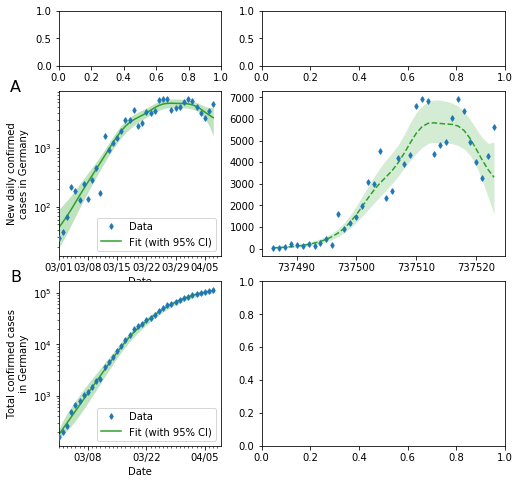

In [18]:
color='tab:green'
ylabel_new = 'New daily confirmed\ncases in Germany'
ylabel_cum = 'Total confirmed cases\nin Germany'
for trace, save_name in zip((trace_rw, trace_not_rw), ('SEIR_rw_cases', 'SEIR_not_rw_cases')):
    fig, axes = plt.subplots(3,2, figsize=(8,8), gridspec_kw={'height_ratios': [1, 3,3],
                                                                'width_ratios': [2, 3]})
    #plt.locator_params(nbins=4)
    pos_letter = (-0.3, 1)
    titlesize = 16
    start_date=datetime.datetime(2020,3,1)
    end_date=datetime.datetime(2020,4,21)

    ax = axes[1][0]
    time_arr = np.arange(-len(cases_obs)+1, 0)
    mpl_dates = conv_time_to_mpl_dates(time_arr) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=4, label='Data', zorder=5)
    new_cases_past = trace.new_cases[:,:num_days_data]
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color, lw=0)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel_new)
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    #plt.savefig(path_to_save + 'check_new_cases.png', dpi=300)

    ax = axes[2][0]
    ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, label='Data', zorder=5)
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),color=color, label='Fit (with 95% CI)')
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color=color, lw=0)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel_cum)
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(mpl_dates[0])

    ax = axes[1][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', label='Data', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)

    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    #ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', linewidth=3)
    #ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')


    new_cases_past = trace.new_cases[:,:num_days_data]
    ax.plot(mpl_dates, np.median(new_cases_past, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(new_cases_past, q=2.5, axis=0), np.percentile(new_cases_past, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color, lw=0)

    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = trace['new_cases'][:, num_days_data:].T
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='Forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color, lw=0)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color, lw=0)

    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel_new)
    ax.legend(loc='upper left')
    ax.set_ylim(0, 15_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format =lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=titlesize)


    ax = axes[2][1]

    time1 = np.arange(-len(cases_obs)+2, 1)
    mpl_dates = conv_time_to_mpl_dates(time1) + diff_data_sim + num_days_data
    ax.plot(mpl_dates, cases_obs[1:], 'd', label='Confirmed cases', markersize=4, color='tab:blue', 
                zorder=5)
    #ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=4, color='tab:blue', 
    #            zorder=6)


    new_cases_past = trace.new_cases[:,:num_days_data]
    cum_cases = np.cumsum(new_cases_past, axis=1) + cases_obs[0]
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),'--',color=color, linewidth=1.5, label='Fit with 95% CI')
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.2, color=color, lw=0)


    time2 = np.arange(0, num_days_future+1)
    mpl_dates_fut = conv_time_to_mpl_dates(time2) + diff_data_sim + num_days_data
    cases_future = np.cumsum(trace['new_cases'][:, num_days_data:].T, axis=0) + cases_obs[-1]
    #cases_future = np.concatenate([np.ones((1,cases_future.shape[1]))*cases_obs[-1], cases_future], axis=0)
    median = np.median(cases_future, axis=-1)
    percentiles = (
        np.percentile(cases_future, q=2.5, axis=-1),
        np.percentile(cases_future, q=97.5, axis=-1),
    )
    ax.plot(mpl_dates_fut[1:], median, color=color, linewidth=3, label='Forecast with 75% and 95% CI')
    ax.fill_between(mpl_dates_fut[1:], percentiles[0], percentiles[1], alpha=0.1, color=color, lw=0)
    ax.fill_between(mpl_dates_fut[1:], np.percentile(cases_future, q=12.5, axis=-1), np.percentile(cases_future, q=87.5, axis=-1),
                    alpha=0.2, color=color, lw=0)

    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel_cum)
    ax.legend(loc='upper left')
    ax.set_ylim(0, 200_000)
    # ax.legend(loc='lower left')
    #ax.set_xticks([-28,-21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    #ax.locator_params(axis="y", nbins=4)
    func_format =lambda num, _: "${:.0f}\,$k".format(num/1_000)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.set_xlim(start_date, end_date)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)
    ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=titlesize)


    ax = axes[0][1]

    time = np.arange(-diff_to_0+1, -diff_to_0+num_days_sim+1)
    lambda_t = trace['lambda_t'][:, :]
    mu = trace['mu'][:,None]
    mpl_dates = conv_time_to_mpl_dates(time) + diff_data_sim + num_days_data

    ax.plot(mpl_dates, np.median(lambda_t-mu, axis=0), color=color, linewidth=2)
    ax.fill_between(mpl_dates, np.percentile(lambda_t-mu , q=2.5, axis=0),np.percentile(lambda_t-mu, q=97.5, axis=0), alpha=0.15,
                    color=color, lw=0)
    #ax.fill_between(mpl_dates, np.percentile(lambda_t , q=12.5, axis=0),np.percentile(lambda_t, q=87.5, axis=0), alpha=0.2,
    #                color=color)

    ax.set_ylabel('Effective\ngrowth rate $\lambda_t^*$')
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    # ax.set_xticks([-28, -21, -14, -7, 0, 7, 14, 21, 28])
    #ax.set_xlim(-28, 14)
    ax.set_ylim(-0.5, 4)
    #ax.set_yticks([-0.2, 0, 0.2])
    #ax.set_aspect(15, adjustable="box")
    ax.hlines(0,start_date, end_date, linestyles=':')
    delay = matplotlib.dates.date2num(date_data_end) - np.percentile(trace.delay, q=75)
    #ax.vlines(delay,-10, 10, linestyles='-', colors=['tab:red'])
    #ax.legend()
    #ax.text(delay+0.5, 3.6, 'unconstrained because\nof reporting delay', color='tab:red', verticalalignment='top')
    #ax.text(delay-0.5, 3.6, 'constrained\nby data', color='tab:red',horizontalalignment='right', verticalalignment='top')
    ax.text(pos_letter[0], pos_letter[1], "C", transform=ax.transAxes, size=titlesize)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(interval=2, byweekday=matplotlib.dates.SU))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
    ax.set_xlim(start_date, end_date)

    axes[0][0].set_visible(False)

    plt.subplots_adjust(wspace=0.4, hspace=.3)
    plt.savefig(path_to_save + save_name + '.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
    plt.savefig(path_to_save + save_name + '.png', dpi=300, bbox_inches='tight', pad_inches = 0)